In [45]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [46]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Keep only rows with filename starting with 'ORIGA'
df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.7)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 421
Test: 181
#############################################
Images suitable for analysis: 602
Glaucoma: 141
Non glaucoma: 461
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

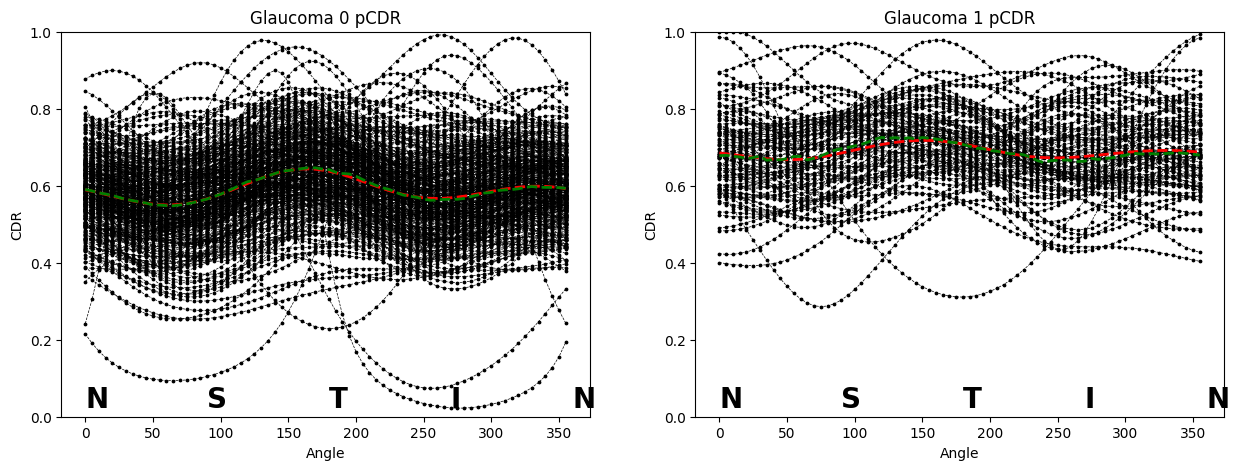

In [47]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

In [48]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    m = np.dot(np.dot(delta, inv_cov), delta.T)
    out = np.sqrt(m)
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.21140142517814728
#############################################
Log prior odds: -1.3164985991843488
Posterior odds information
count     9.100000e+01
mean      1.811146e+15
std       1.716457e+16
min      5.510348e-127
25%       1.001685e-02
50%       3.437607e-02
75%       5.026138e-01
max       1.637480e+17
Name: log_posterior_odds, dtype: float64


/tmp/ipykernel_704692/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)
/tmp/ipykernel_704692/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)


Text(0.5, 1.0, 'Posterior probability of patients (test set)')

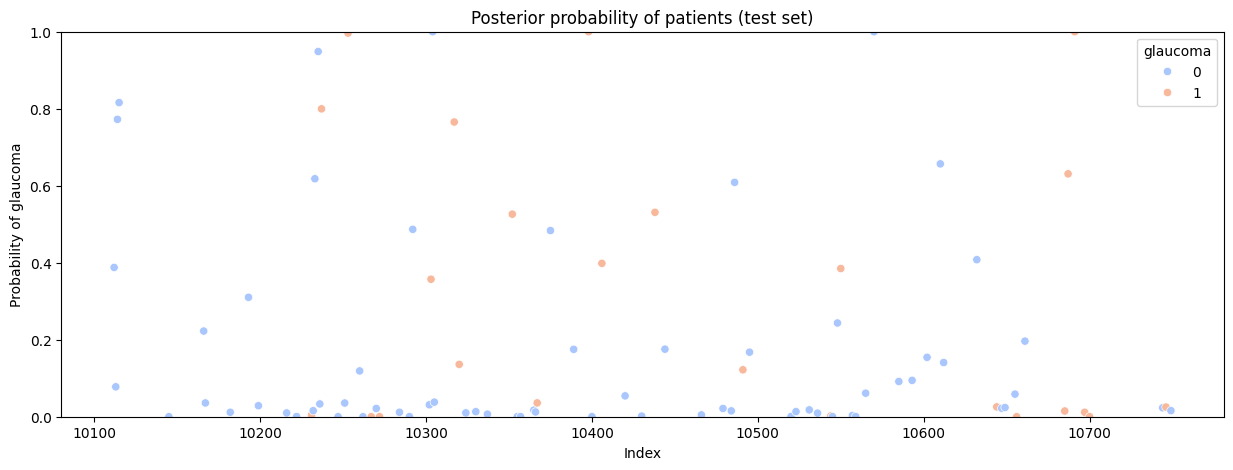

In [49]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    mahal = mahalanobis(x=x, mu=mu, cov=v)
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahal.diagonal()
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / train.shape[0] # ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
print('Prior probability of glaucoma:', prior_glaucoma)
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI
# Print DDI distribution information
print(f'Log prior odds: {log_prior_odds}')
# Posterior odds information
print('Posterior odds information')
print(np.exp(test2['log_posterior_odds']).describe())

# Posterior probability of glaucoma
test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# Scatter plot of posterior probability of suspected glaucoma
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
plt.ylim(0, 1)
plt.xlabel('Index')
plt.ylabel('Probability of glaucoma')
plt.title('Posterior probability of patients (test set)')

In [50]:
# Create a dataframe with column names ['filename', 'glaucoma', 'angle', 'pcdr']
train_mdl = pd.DataFrame(columns=['filename', 'glaucoma', 'angle', 'pcdr'])

# Initialize a list to collect new rows
new_rows = []

for i, row in train.iterrows():
    # Get filename and glaucoma status
    filename = row['filename']
    glaucoma = row['glaucoma']
    # Iterate over each angle
    for id, col in enumerate(train.columns[2:]):
        angle = int(col.split('_')[1])
        pcdr = row[col]
        # Add data to the list of new rows
        new_rows.append({'filename': filename, 'glaucoma': glaucoma, 'angle': angle, 
                         'd':angle/5 + 1, 'd_id': id, 
                         'pcdr': pcdr}) 

# Create a new DataFrame from the list of new rows
train_mdl = pd.DataFrame(new_rows)
        
train_mdl

,filename,glaucoma,angle,d,d_id,pcdr
0,ORIGA-204.png,0,0,1.0,0,0.464487
1,ORIGA-204.png,0,5,2.0,1,0.470290
2,ORIGA-204.png,0,10,3.0,2,0.476386
3,ORIGA-204.png,0,15,4.0,3,0.482710
4,ORIGA-204.png,0,20,5.0,4,0.489199
...,...,...,...,...,...,...
30307,ORIGA-415.png,0,335,68.0,67,0.499069
30308,ORIGA-415.png,0,340,69.0,68,0.500835
30309,ORIGA-415.png,0,345,70.0,69,0.501640
30310,ORIGA-415.png,0,350,71.0,70,0.501434


In [51]:
formula = 'pcdr ~ 1 + np.sin(2*np.pi*d/72) + np.cos(2*np.pi*d/72) + np.sin(4*np.pi*d/72) + np.cos(4*np.pi*d/72)'

# Mixed LM model
model = smf.mixedlm(formula, train_mdl, groups=train_mdl['glaucoma'],
                    re_formula='1', vc_formula={'glaucoma:d_id': '0 + C(d_id)'})

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     pcdr      
No. Observations:       30312       Method:                 REML      
No. Groups:             2           Scale:                  0.0102    
Min. group size:        6408        Log-Likelihood:         26379.5906
Max. group size:        23904       Converged:              Yes       
Mean group size:        15156.0                                       
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.639    0.071   8.966 0.000  0.499  0.779
np.sin(2 * np.pi * d / 72) -0.001    0.001  -1.634 0.102 -0.003  0.000
np.cos(2 * np.pi * d / 72) -0.021    0.001 -26.063 0.000 -0.022 -0.019
np.sin(4 * np.pi * d / 72) -0.015    0.001 -17.175 0.000 -0.017 -0.013
np.cos(4 * np.pi * d / 

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
